In [23]:
%matplotlib inline

In [24]:
import numpy as np
import math
from numpy.polynomial.polynomial import Polynomial
import matplotlib.pyplot as plt

In [25]:
f__0 = 0
f__T = 3 * np.pi

def f(x):
    if 0 <= x < np.pi:
        return np.sin(x)
    if np.pi <= x <= 3 * np.pi:
        return np.sin(x - np.pi)


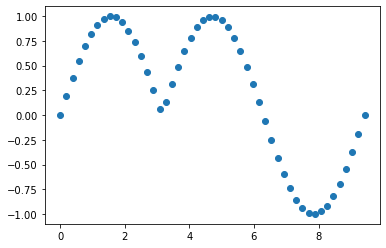

In [26]:

mesh = np.linspace(f__0, f__T, 50, dtype='float64')
values = [f(knot) for knot in mesh]
plt.scatter(mesh, values)

In [27]:
f__0 = 0
f__T = 2 * np.pi + 0.5

def f(x):
    if 0 <= x < np.pi:
        return np.sin(x - np.pi)
    if np.pi <= x <= 2 * np.pi + 0.5:
        return np.sin(x - np.pi - 0.5)


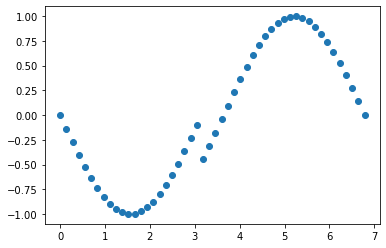

In [28]:

mesh = np.linspace(f__0, f__T, 50, dtype='float64')
values = [f(knot) for knot in mesh]
plt.scatter(mesh, values)

In [29]:
def interpolate(knots, values): # NUMERYCZNIE NIEPOPRAWNE!!!!!! plus zła implementacja
    # Wyznacza listę wielomianów bazowych Lagrange'a dla podanych węzłów interpolacji.
    base = []
    inx = list(range(len(knots)))
    for k in inx:
        zeros = np.take(knots, inx[:k] + inx[k+1:])
        multipier = 1 / (knots[k] - zeros).prod()
        polynomial = Polynomial.fromroots(zeros) * multipier
        base.append(polynomial)

    # Wyznacza wielomian
    polynomial = Polynomial([0.])
    for k in range(len(knots)):
        polynomial += values[k] * base[k]
    return polynomial

In [30]:
from scipy import interpolate

def A_test(f, a0, a1, b1, b0, r, rho):
    knots = np.linspace(b1, b0, r+1, endpoint=True)
    values = np.array([f(x) for x in knots])
    w1 = interpolate.interp1d(knots, values, fill_value="extrapolate")
    # w1 = interpolate(knots, values) # NIE dziala poprawinie dla okolo r > 3
    
    knots = np.linspace(a0, a1, r+1, endpoint=True)
    values = np.array([f(x) for x in knots])
    w2 = interpolate.interp1d(knots, values, fill_value="extrapolate")
    # w2 = interpolate(knots, values)
    
    z_arr = np.linspace(a1, b1, r+1, endpoint=True) # "endpoint=True" is 100% good here
    values = [(np.abs(w1(z_i) - w2(z_i))) / ((b0 - a0) ** (r + rho)) for z_i in z_arr]
    
    # print("a0: {}   b0: {}   test_result: {}".format(a0, b0, result))
    # print("f(a0): {}   w1(a0): {}".format(f(a0), f(b0)))
    return np.max(values)

In [31]:
def step1(g, c, delta, r, rho):
    max_diam = np.max([c[i+1] - c[i] for i in range(len(c)-1)])
    
    if max_diam <= 4 * delta:
        return 0, 0
    else:
        largest_result = 0
        second_largest_result = 0
        lagrest_result_index = 0

        for i in range(len(c)-1):
            if c[i+1] - c[i] > 4 * delta:
                # print("c[i]: {}, c[i] + delta: {}, c[i+1] - delta: {}, c[i+1]: {}".format(c[i], c[i] + delta, c[i+1] - delta, c[i+1]))
                test_result = A_test(g, c[i], c[i] + delta, c[i+1] - delta, c[i+1], r, rho)
                # print("i: {}   [{:.6f}, {:.6f}] -> test_result: {}".format(i, c[i], c[i+1], test_result))

                if test_result > largest_result:
                    largest_result = test_result
                    lagrest_result_index = i
                elif largest_result > test_result > second_largest_result:
                    second_largest_result = test_result
        
        if math.isclose(largest_result, second_largest_result, rel_tol=1e-7):
            print("HERE10")
            return 0, 0

    # print("delta: {}".format(delta))
    # print("lagrest_result_index: {}".format(lagrest_result_index))
    return c[lagrest_result_index], c[lagrest_result_index+1]

In [32]:
def step2(g, a, b, delta, r, rho): # bisection
    if a == 0 and b == 0:
        return []
    a_new, b_new = a, b
    B = [a, b]

    while True:
        if b_new - a_new <= 4 * delta:
            # print("HERE1")
            return B
        
        v = (a_new + b_new) / 2
        A1 = A_test(g, a_new, a_new +  delta, v - delta, v, r, rho)
        A2 = A_test(g, v, v +  delta, b_new - delta, b_new, r, rho)
        B.append(v)

        if math.isclose(A1, A2, rel_tol=1e-14):  # TODO: it should depend on precision
            # print("HERE2")
            return B
        elif A1 > A2:
            b_new = v    
        else:
            a_new = v

In [33]:
def step3(g, c, B, delta):
    M = np.concatenate((c, B))
    M = np.sort(M)

    def adaptive_approximate(t):
        # locate knot that is smaller or equal to t (and it is closest to t)
        # print("t equals: {}".format(t))
        for i in range(len(M)-1):
            # print("t: {}   i: {}   M[i]: {}".format(t, i, M[i]))
            if t < M[i+1]:
                break
                
        # print("i: {}\t M[i]: {:.8f} t: {:.8f} --- [{:.8f} {:.8f} {:.8f} {:.8f}]".format(i, M[i], t, M[i], M[i] + delta, M[i+1] - delta, M[i+1]))
        
        if M[i+1] - M[i] <= 4 * delta:
            # print("small interval")
            return g(M[i])
        else:
            # print("not small interval -> ", end='')
            if M[i] <= t < M[i] + delta:
                # print("left")
                return g(M[i])
            if M[i] + delta <= t < M[i+1] - delta:
                # print("central")
                left, right = M[i] + delta, M[i+1] - delta
                knots = np.linspace(left, right, r+1, endpoint=True)
                values = np.array([g(x) for x in knots])
                polynomial = interpolate.interp1d(knots, values)
                return polynomial(t)
            if M[i+1] - delta <= t < M[i+1]:
                # print("right")
                return g(M[i+1] - delta)

        if math.isclose(t, M[-1]):
            # print("end of interval")
            return g(M[-1])

        return -1
    return M, adaptive_approximate

In [34]:
def Alg2014(g, a, b, m, r, rho):
    '''
    g - funkcja, którą aproksymujemy
    r - regularność funkcji
    a, b - brzegi przedziału [a,b]
    m - początkowa gęstość siatki
    '''
    # Step 0 (inicjalizacja stałych itp.)
    h = (b - a) / m
    delta = h ** (r + rho)
    c = np.linspace(a, b, m+1, dtype='float64', endpoint=True) # mamy m+1 wezlów postaci c[0], ... , c[m]

    # kroki algorytmu
    # Krok 1: Lokalizowanie osobliwosci
    left, right = step1(g, c, delta, r, rho)
    # print("przedzial z osobliwoscia: [{}, {}]".format(left, right))

    # Krok 2: Wybieranie dodatkowych punktów metoda bisekcji
    B = step2(g, left, right, delta, r, rho)
    # print("B(qty: {}): {}".format(len(B), B))
    
    # Krok 3: konstruowanie finalnej aproksymacji
    M, approx = step3(g, c, B, delta)
    # print("M: {}".format(M))
    
    return M, approx


In [35]:
m = 200
r = 3
rho = 10e-4

M, f_approximation = Alg2014(f, f__0, f__T, m, r, rho)

In [36]:
def f_values(mesh, fun):
    return [fun(knot) + 0.1 for knot in mesh]

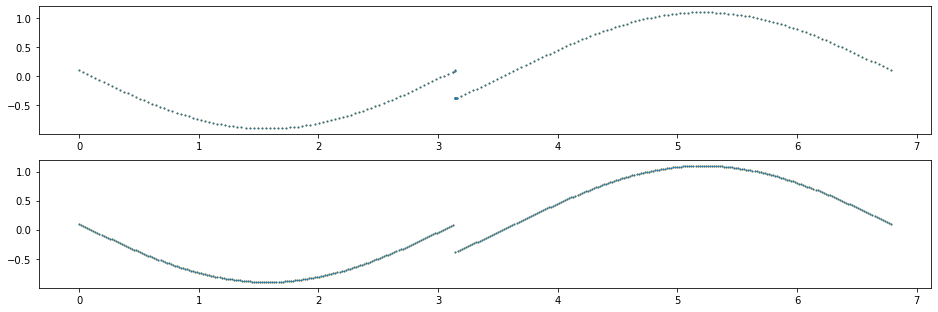

In [37]:
plt.figure(figsize=(16, 8))

plt.subplot(3, 1, 1) # row 1, col 2 index 1
plt.scatter(M, f_values(M, f), color="orange", s=1)
plt.scatter(M, f_values(M, f_approximation), s=1)

plt.subplot(3, 1, 2) # index 2
mesh = np.linspace(f__0, f__T, num=m*2, endpoint=True)
plt.scatter(mesh, f_values(mesh, f), color="orange", s=1)
plt.scatter(mesh, f_values(mesh, f_approximation), s=1)

# plt.subplot(3, 1, 3)
# mesh = np.linspace(f__0, f__T, num=m, endpoint=True)
# plt.scatter(mesh, f_values(mesh, f_approximation), s=1)
# plt.scatter(mesh, f_values(mesh, f_approximation), color="green", s=1)

In [38]:
# mesh  = np.linspace(f__0, f__T, num=50) # endpoint should be included...

# for elem in mesh:
#     print("(x, y): ({}, {})".format(elem, f_approximation(elem)))


In [52]:
import scipy.integrate as integrate

def worst_case_error(fun, algorithm, alg_data, num, p=2):
    '''
    calculate worst case error with respect to noise for function fun
    '''
    f__a, f__b, m, r, rho = [value for value in alg_data]
    norms = []
    errors = []

    for i in range(num):
        f_approximation = algorithm(f, f__a, f__b, m, r, rho)[1]
        result, error = integrate.quad(lambda x: abs(f(x) - f_approximation(x))**p, f__a, f__b)
        norm = result**(1/p)
        norms.append(norm)
        errors.append(error) # ERORRS OF INTEGRATION!!! not errors of approximation

    print("norms: ")
    print(["{:.8f}, ".format(value) for value in norms])
    # print("errors: ")
    # print(["{:.13f}, ".format(value) for value in errors])

    return np.max(norms)

In [53]:
m, r, rho = 100, 3, 10e-4

worst_case_error(
    fun=f, 
    algorithm=Alg2014,
    alg_data=(f__0, f__T, m, r, rho),
    num=5)

norms: 
['0.00006364, ', '0.00006364, ', '0.00006364, ', '0.00006364, ', '0.00006364, ']


6.364329848193089e-05